# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of those places, and collects detailed data on the number of bicyles people rent by the hour and the day.

## Data Set
This data contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The relevant columns are:

- ```instant``` - A unique sequential ID number for each row
- ```dteday``` - The date of the rentals
- ```season``` - The season in which the rentals occurred
- ```yr``` - The year the rentals occurred
- ```mnth``` - The month the rentals occurred
- ```hr``` - The hour the rentals occurred
- ```holiday``` - Whether or not the day was a holiday
- ```weekday``` - The day of the week (as a number, 0 to 7)
- ```workingday``` - Whether or not the day was a working day
- ```weathersit``` - The weather (as a categorical variable)
- ```temp``` - The temperature, on a 0-1 scale
- ```atemp``` - The adjusted temperature
- ```hum``` - The humidity, on a 0-1 scale
- ```windspeed``` - The wind speed, on a 0-1 scale
- ```casual``` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- ```registered``` - The number of registered riders (people who had already signed up)
- ```cnt``` - The total number of bike rentals (casual + registered)

## Goal
Build a machine learning pipeline that will predict the total number of bikes people rented in a given hour. We will use the ```cnt``` column as our target column, and decide which columns to use except for ```casual``` and ```registered```.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression



import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    linewidth=4
    )


%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')



In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.shape

(17379, 17)

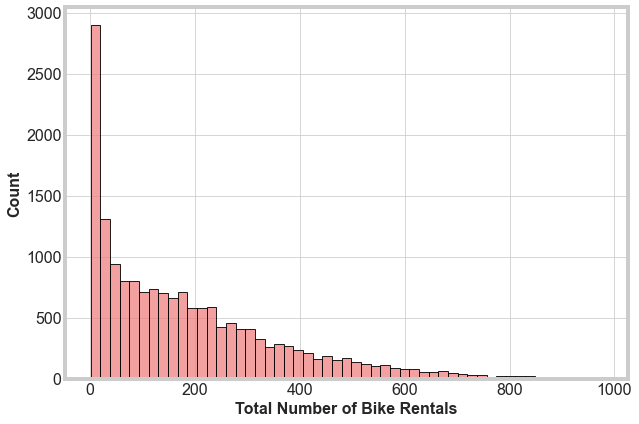

In [12]:
plt.figure(figsize=(9,6))


sns.histplot(data=bike_rentals,x='cnt',color='lightcoral')
plt.xlabel('Total Number of Bike Rentals',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

In [6]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We see that the histogram of the total rentals is heavily right-skewed. The columns that have correlation constant of at least 0.25 include 

- ```instant```: 0.27
- ```yr```: 0.25
- ```hr```: 0.39
- ```temp```: 0.40
- ```atemp```: 0.40
- ```hum```: 0.32

##  Feature Engineering

Let's engineer a few features that are more relevant and helpful for our pipeline.

The ```hr``` column contains the hours bikes are rented, from 1 to 24. Let's create a new column, grouping these hours by morning, afternoon, evening, and night. 



In [7]:
def assign_label(value):
    if value >= 6 and value < 12:
        return 1
    elif value >= 12 and value < 18:
        return 2
    elif value >= 18 and value < 24:
        return 3
    elif value >= 0 and value < 24:
        return 4

In [8]:
print(assign_label(144))

None


In [9]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [10]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Split Data into Train and Test Sets

We're ready now to split the data into train and test sets. We'll start with using 80% of the data to train. Later, we'll use cross-validation to improve our testing. We'll use the mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.


In [11]:
train = bike_rentals.sample(frac=0.8)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

We're now ready to start fitting models to the data. We will start with a linear regression model. Linear regression works best when features are linearly correlated with the target and independent. 

In [12]:
features = train.columns.tolist()
features.remove('cnt')
features.remove('casual')
features.remove('dteday')
features.remove('registered')

In [13]:
lr = LinearRegression()

lr.fit(train[features],train['cnt'])

lr_predictions = lr.predict(test[features])

lr_mse = mean_squared_error(test['cnt'],lr_predictions)

print(lr_mse)

17154.50735933943


This is a very high MSE. This is likely a result of the fact that the ```cnt``` column has a large number of small rentals. Missing these values significantly would increase the MSE quickly. 

## Decision Tree

Next, let's try a decision tree regressor. We can compare this to the linear regression model to decide on the best algorithm for this dataset. 

In [14]:

dtr = DecisionTreeRegressor(min_samples_leaf=5)

dtr.fit(train[features],train['cnt'])

dtr_predictions = dtr.predict(test[features])

dtr_mse = mean_squared_error(test['cnt'],dtr_predictions)

print(dtr_mse)


2498.0731347900737


Our error is significantly improved with the decision tree model. 

## Random Forest

Finally, lets try a random forest algorithm. 

In [15]:
rfr = RandomForestRegressor(min_samples_leaf=1)

rfr.fit(train[features],train['cnt'])

rfr_predictions = rfr.predict(test[features])

rfr_mse = mean_squared_error(test['cnt'],rfr_predictions)

print(rfr_mse)



1617.4444990218644


Unsurprisingly, the random forest algorithm performs the best between the three models. Let's focus on this model to refine the features to use and hyperparameters.

## Feature Selection

We briefly looked at correlations between features and the target. Now, let use those to see if dropping any features can improve our model. We will first build a test and train function to quickly test our selections, and include cross-validation. At this point, we will use the default setting on the ```RandomForestRegressor```. In the next step we will tune these parameters.

In [16]:
def test_and_train(df,training_col,target_col):
    rfr = RandomForestRegressor()
    kf = KFold(n_splits=5,shuffle=True)
    
    mses = cross_val_score(rfr,
                          df[training_col],
                          df[target_col],
                          scoring='neg_mean_squared_error',
                          cv=kf)
    
    final_mse = np.absolute(np.mean(mses))
    return final_mse


In [17]:
# drop a single column each time

features = train.columns.tolist()
features.remove('cnt')
features.remove('casual')
features.remove('dteday')
features.remove('registered')

mse_results = {}

for x in features:
    new_features = features.copy()
    new_features.remove(x)
    this_mse = test_and_train(bike_rentals,new_features,'cnt')
    dict_key = 'no_' + x
    mse_results[x] = this_mse
    
print(pd.DataFrame.from_dict(mse_results,orient='index'))

                       0
instant      1819.873002
season       1680.205061
yr           1688.439184
mnth         1664.241653
hr          11385.282090
holiday      1700.697592
weekday      1915.790999
workingday   1829.035663
weathersit   1846.299867
temp         1648.601972
atemp        1674.113163
hum          1807.264020
windspeed    1642.422051
time_label   1705.228951


In [18]:
# look at mutual information

importances = mutual_info_regression(bike_rentals[features],
                               bike_rentals['cnt'])

feat_importances = pd.Series(importances)
feat_importances.index = bike_rentals[features].columns


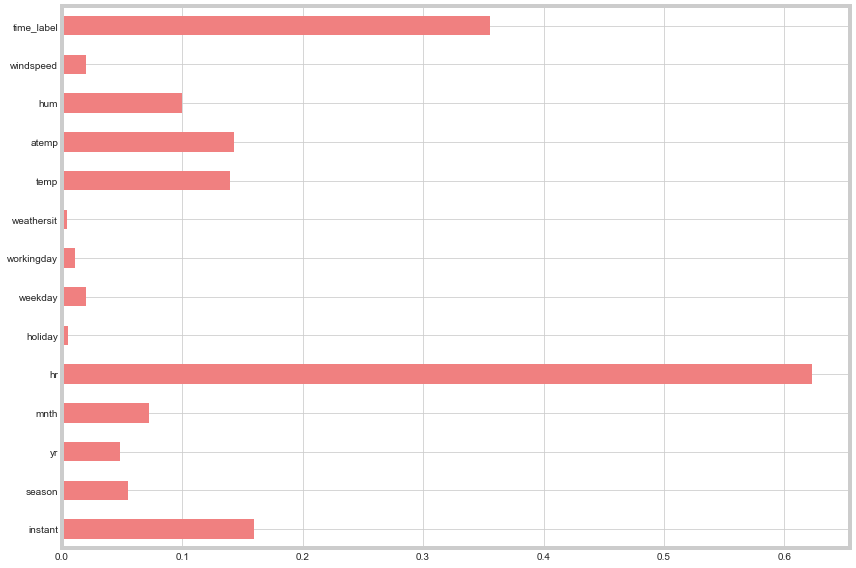

In [19]:
plt.figure(figsize=(12,8))
feat_importances.plot(kind='barh',color='lightcoral')
plt.show()

Windspeed, weathersit, workingday, weekday, and holiday have very little mutual information. Unsurprisingly, these columns also have limited correlation values with the target column. Let's try dropping these columns to see if it improves our results.

In [20]:
limited_features = bike_rentals.columns.tolist()
limited_features.remove('cnt')
limited_features.remove('casual')
limited_features.remove('dteday')
limited_features.remove('registered')
limited_features.remove('windspeed')
limited_features.remove('weathersit')
limited_features.remove('workingday')
limited_features.remove('weekday')
limited_features.remove('holiday')


limited_mse = test_and_train(bike_rentals,limited_features,'cnt')

print(limited_mse)


6474.042784960095


Dropping all of these features increased the error significantly. Though the mutual information on each individual feature is low, collectively they appear to provide important information we'll keep. 

## Hyperparameter Testing

Now that we have selected our features, we can move to fine tuning our random forest parameters. For this, we'll conduct a randomized grid search across possible parameters before fine-tuning our choices.

In [21]:
# Set up grid of parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [22]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()


search_grid = RandomizedSearchCV(rf,
                                param_distributions = random_grid,
                                n_iter = 100,
                                cv = 2,
                                verbose = 1,
                                n_jobs = -1)

search_grid.fit(train[features],train['cnt'])

Fitting 2 folds for each of 100 candidates, totalling 200 fits


/Users/josh.fuchs/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=1)

In [25]:
search_grid.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [27]:
search_grid_results = pd.DataFrame.from_dict(search_grid.cv_results_)
search_grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,10.305452,0.058350,1.814226,0.011407,800,5,1,sqrt,90,False,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.885008,0.880915,0.882962,0.002047,46
1,99.492102,0.653973,5.094592,0.165618,2000,2,2,auto,110,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.897304,0.897856,0.897580,0.000276,30
2,10.484933,0.126729,2.213811,0.051986,1200,5,1,sqrt,50,True,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.863343,0.859781,0.861562,0.001781,60
3,10.292024,0.015540,1.758998,0.031997,1000,2,4,sqrt,110,False,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.859235,0.856408,0.857822,0.001414,70
4,51.482949,0.200256,1.668186,0.016086,1600,10,4,auto,10,False,"{'n_estimators': 1600, 'min_samples_split': 10...",0.891202,0.879219,0.885211,0.005991,42


In [31]:
search_grid_results.sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
18,84.214134,0.013595,6.145330,0.029057,2000,2,1,auto,None,True,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.939338,0.939646,0.939492,0.000154,1
77,28.254435,0.371365,1.647282,0.135813,600,2,1,auto,70,True,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.939210,0.939660,0.939435,0.000225,2
92,67.116131,0.138315,2.943558,0.311016,1800,2,2,auto,60,True,"{'n_estimators': 1800, 'min_samples_split': 2,...",0.937919,0.939295,0.938607,0.000688,3
46,40.133485,0.251162,2.252275,0.019189,1200,5,1,auto,90,True,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.938061,0.938966,0.938514,0.000452,4
87,53.845454,0.441432,3.060728,0.089531,1400,5,2,auto,70,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.937297,0.938994,0.938145,0.000848,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,11.226081,0.257995,2.765963,0.138389,800,5,4,sqrt,90,True,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.831860,0.827608,0.829734,0.002126,96
27,10.365937,0.078619,1.693297,0.101758,1200,2,4,sqrt,20,True,"{'n_estimators': 1200, 'min_samples_split': 2,...",0.834016,0.825109,0.829563,0.004453,97
29,14.528657,0.313112,2.552863,0.051156,1600,10,4,sqrt,80,True,"{'n_estimators': 1600, 'min_samples_split': 10...",0.829880,0.827224,0.828552,0.001328,98
65,5.316931,0.081528,0.807979,0.038499,600,10,4,sqrt,50,True,"{'n_estimators': 600, 'min_samples_split': 10,...",0.829693,0.826885,0.828289,0.001404,99


In [32]:
search_grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

###### heatmap_data = pd.pivot_table(search_grid_results, values='mean_test_score',
                             index=['param_min_samples_split'],
                             columns='param_n_estimators')

sns.set(rc={'figure.figsize':(14,7)})
sns.heatmap(heatmap_data, annot = True, cmap='viridis')


Across a few different parameters, we see there is not a large difference in performance. This means that our dataset and model are relatively insensitive to changes in the hyperparameters. 

## Final Model

To wrap up this project, we will run the final model using the features and hyperparameters we decided on above.

In [36]:
rfr = RandomForestRegressor(n_estimators= 2000,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'auto',
                            max_depth= None,
                            bootstrap= True)
kf = KFold(n_splits=5,shuffle=True)

training_col = bike_rentals.columns.tolist()
training_col.remove('cnt')
training_col.remove('casual')
training_col.remove('dteday')
training_col.remove('registered')

target_col = 'cnt'
    
mses = cross_val_score(rfr,
                      bike_rentals[training_col],
                      bike_rentals[target_col],
                      scoring='neg_mean_squared_error',
                      cv=kf)
    
final_mse = np.absolute(np.mean(mses))
print(final_mse)

1643.5554236568246
